# Overview

This notebook aims to predict the return of S&P 500 stocks using an LSTM neural network. It downloads historical stock data from Yahoo Finance, preprocesses the data, creates a custom dataset, trains an LSTM model, and evaluates its performance using a validation set.

# Imports

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

import os
import random
import numpy as np

In [2]:
# Set a seed so that results can be reproduced
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)               # PyTorch CPU
    torch.cuda.manual_seed(seed)          # PyTorch GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

# Data

In [3]:
# We are going to use the top 500 companies to extract data from Yahoo finance.
# https://datahub.io/core/s-and-p-500-companies
stock_names = pd.read_csv("constituents.csv")
stock_names.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [4]:
start_date = "2010-01-01"
end_date = "2024-12-31"

In [5]:
data = {}

for symbol in stock_names["Symbol"]:
    path = f"data/{symbol}.csv"
    if os.path.exists(path):
        data[symbol] = pd.read_csv(path, index_col='Date', parse_dates=True)

for symbol in stock_names["Symbol"]:
    if symbol in data:
        continue
    df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

    path = f"data/{symbol}.csv"
    if not os.path.exists(path):
        df.to_csv(path)
        
    data[symbol] = df

In [6]:
class StockDataset(Dataset):
    """
    Custom data for stock data.  Used to predict the return for "future_prediction" days in the future.
    """
    def __init__(self, stock_dict, window_size=30, future_prediction=7):
        self.X = []
        self.Y = []
        self.window_size = window_size
        
        for symbol, df in stock_dict.items():
            df = df.dropna()
            df['Return'] = df['Close'].pct_change(future_prediction).shift(-1 * future_prediction)
            df = df.dropna()
            
            features = df[['Open', 'High', 'Low', 'Close', 'Volume']].values
            targets = df['Return'].values
            
            for i in range(len(df) - window_size - future_prediction):
                x = features[i:i+window_size]
                y = targets[i+window_size - 1 + future_prediction]
                self.X.append(torch.tensor(x, dtype=torch.float32))
                self.Y.append(torch.tensor(y, dtype=torch.float32))
                
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return (self.X[idx], self.Y[idx])

# Model

In [7]:
class StockLSTM(nn.Module):
    def __init__(self, input_size=5, hidden_size=64, num_layers=2, dropout=0.2):
        super(StockLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Take the last time step
        out = self.fc(out)
        return out.squeeze()

# Train

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# Parameters
batch_size = 32
window_size = 30
epochs = 5

# Model Parameters
lstm_layers = 2
lstm_hidden_size = 64
dropout = 0.2

In [10]:
dataset = StockDataset(data, window_size=window_size)

In [11]:
train_pct = 0.8

train_size = int(train_pct * len(dataset))
valid_size = len(dataset) - train_size

# Slice the dataset directly to preserve order
train_set = torch.utils.data.Subset(dataset, list(range(train_size)))
valid_set = torch.utils.data.Subset(dataset, list(range(train_size, len(dataset))))

In [12]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size)

In [13]:
model = StockLSTM(hidden_size = lstm_hidden_size, num_layers=lstm_layers, dropout=dropout)
model.to(device)

StockLSTM(
  (lstm): LSTM(5, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [14]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
train_losses = []
valid_losses = []
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        preds = model(x_batch.to(device))
        loss = criterion(preds, y_batch.to(device))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_losses.append(train_loss/len(train_loader))
    
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in valid_loader:
            preds = model(x_batch.to(device))
            loss = criterion(preds, y_batch.to(device))
            valid_loss += loss.item()
            
        
    valid_losses.append(valid_loss/len(valid_loader))
    
    print(f"Epoch {epoch + 1}:\n\tTrain Loss = {train_losses[-1]:.4f}\n\tValid Loss = {valid_losses[-1]:.4f}")

Epoch 1:
	Train Loss = 0.0025
	Valid Loss = 0.0028
Epoch 2:
	Train Loss = 0.0025
	Valid Loss = 0.0028
Epoch 3:
	Train Loss = 0.0025
	Valid Loss = 0.0028
Epoch 4:
	Train Loss = 0.0025
	Valid Loss = 0.0028
Epoch 5:
	Train Loss = 0.0025
	Valid Loss = 0.0028


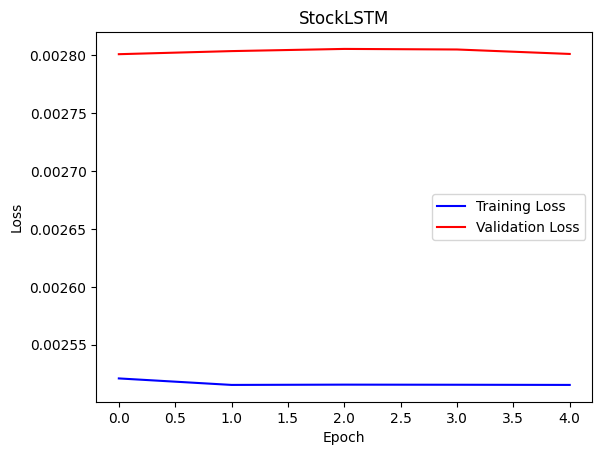

In [16]:
plt.title(model.__class__.__name__)
plt.plot(train_losses, color='blue', label='Training Loss')
plt.plot(valid_losses, color='red', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()